In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
# Data transformations for training and validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '../data/oxford-flowers17'
image_datasets = {x: datasets.ImageFolder(f'{data_dir}/{x}', data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True)
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
len(dataloaders['train'].dataset), len(dataloaders['val'].dataset)

device(type='cpu')

## SqueezeNet
Ref: https://medium.com/@wengsengh/test-f4eddce38aff

In [46]:
model_squeezenet = models.squeezenet1_1(weights=models.SqueezeNet1_1_Weights.DEFAULT)

num_classes = len(class_names)
# Replace the classifier part of the model
model_squeezenet.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1, 1))
model_squeezenet.num_classes = num_classes

model_squeezenet = model_squeezenet.to(device)
# Freeze all layers in the feature extractor
for param in model_squeezenet.features.parameters():
    param.requires_grad = False

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_squeezenet.classifier.parameters(), lr=0.001)

In [47]:
model_squeezenet.classifier

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Conv2d(512, 17, kernel_size=(1, 1), stride=(1, 1))
  (2): ReLU(inplace=True)
  (3): AdaptiveAvgPool2d(output_size=(1, 1))
)

In [48]:
def train_model(model, criterion, optimizer, num_epochs=10):
    train_losses, valid_losses = [], []
    train_accs, valid_accs = [], []
    for epoch in range(num_epochs):
        model.train()
        train_acc, train_loss = 0, 0
        for inputs, labels in dataloaders['train']:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_acc += (predicted == labels).sum().item()

        train_acc /= dataset_sizes['train']
        train_loss /= len(dataloaders['train'])
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation loop
        model.eval()
        valid_acc, valid_loss = 0, 0
        with torch.no_grad():
            for inputs, labels in dataloaders['val']:
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                valid_acc += (predicted == labels).sum().item()
                valid_loss += criterion(outputs, labels).item()
        
        valid_acc /= dataset_sizes['val']
        valid_loss /= len(dataloaders['val'])
        valid_losses.append(valid_loss)
        valid_accs.append(valid_acc)
                

        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.4f}")

    return model, train_losses, valid_losses, train_accs, valid_accs

# Train SqueezeNet
model_squeezenet, train_losses, valid_losses, train_accs, valid_accs = train_model(model_squeezenet, criterion, optimizer, num_epochs=10)

Epoch 1, Train Loss: 2.2799, Train Acc: 0.3294, Valid Loss: 1.3291, Valid Acc: 0.6912
Epoch 2, Train Loss: 1.1527, Train Acc: 0.6985, Valid Loss: 0.6769, Valid Acc: 0.8147
Epoch 3, Train Loss: 0.6835, Train Acc: 0.8294, Valid Loss: 0.4807, Valid Acc: 0.8471
Epoch 4, Train Loss: 0.5334, Train Acc: 0.8500, Valid Loss: 0.3267, Valid Acc: 0.9088
Epoch 5, Train Loss: 0.4171, Train Acc: 0.8956, Valid Loss: 0.2913, Valid Acc: 0.9235
Epoch 6, Train Loss: 0.3684, Train Acc: 0.8971, Valid Loss: 0.2964, Valid Acc: 0.9088
Epoch 7, Train Loss: 0.3164, Train Acc: 0.9176, Valid Loss: 0.2359, Valid Acc: 0.9382
Epoch 8, Train Loss: 0.3008, Train Acc: 0.9250, Valid Loss: 0.2461, Valid Acc: 0.9294
Epoch 9, Train Loss: 0.2804, Train Acc: 0.9265, Valid Loss: 0.2233, Valid Acc: 0.9294
Epoch 10, Train Loss: 0.2105, Train Acc: 0.9412, Valid Loss: 0.2108, Valid Acc: 0.9382


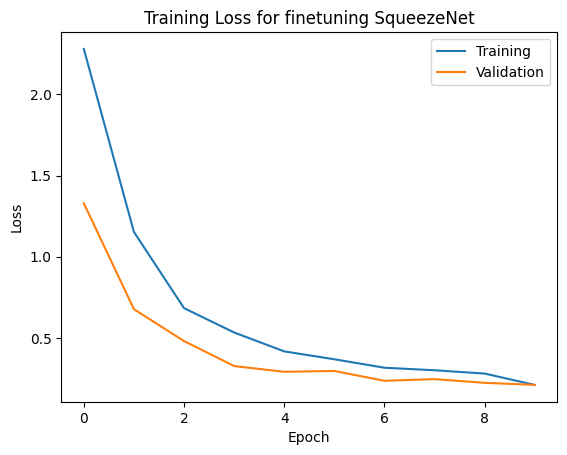

In [49]:
# Plot the loss curve
plt.plot(train_losses, label="Training")
plt.plot(valid_losses, label="Validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss for finetuning SqueezeNet")
plt.show()

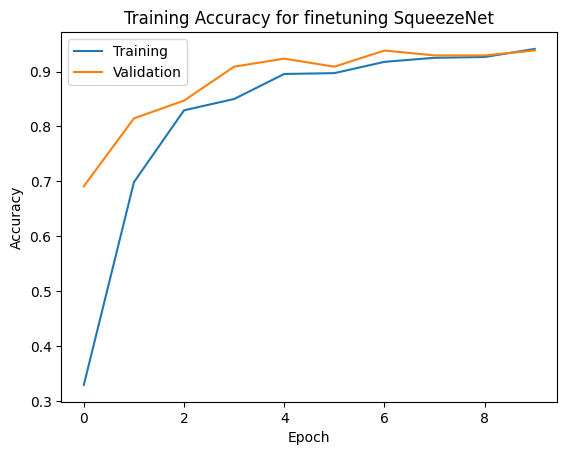

In [50]:
# Plot the accuracy curve
plt.plot(train_accs, label="Training")
plt.plot(valid_accs, label="Validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy for finetuning SqueezeNet")
plt.show()

## Custom CNN

In [41]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(256 * 28 * 28, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the features
        x = self.classifier(x)
        return x

# Initialize and train the custom CNN
model_custom = CustomCNN(num_classes)
optimizer_custom = optim.Adam(model_custom.parameters(), lr=0.001)
model_custom, train_losses, valid_losses, train_accs, valid_accs = train_model(model_custom, criterion, optimizer_custom, num_epochs=10)

Epoch 1, Train Loss: 3.6082, Train Acc: 0.1176, Valid Loss: 2.3449, Valid Acc: 0.2000
Epoch 2, Train Loss: 2.3172, Train Acc: 0.2147, Valid Loss: 2.0291, Valid Acc: 0.2941
Epoch 3, Train Loss: 2.1241, Train Acc: 0.2485, Valid Loss: 1.7558, Valid Acc: 0.4206
Epoch 4, Train Loss: 2.0039, Train Acc: 0.3103, Valid Loss: 1.6772, Valid Acc: 0.4118
Epoch 5, Train Loss: 1.9064, Train Acc: 0.3368, Valid Loss: 1.7077, Valid Acc: 0.4265
Epoch 6, Train Loss: 1.8643, Train Acc: 0.3603, Valid Loss: 1.4995, Valid Acc: 0.5088
Epoch 7, Train Loss: 1.8987, Train Acc: 0.3515, Valid Loss: 1.6779, Valid Acc: 0.4647
Epoch 8, Train Loss: 1.7682, Train Acc: 0.3897, Valid Loss: 1.4377, Valid Acc: 0.4765
Epoch 9, Train Loss: 1.6839, Train Acc: 0.4338, Valid Loss: 1.4496, Valid Acc: 0.5059
Epoch 10, Train Loss: 1.6026, Train Acc: 0.4485, Valid Loss: 1.3726, Valid Acc: 0.5176


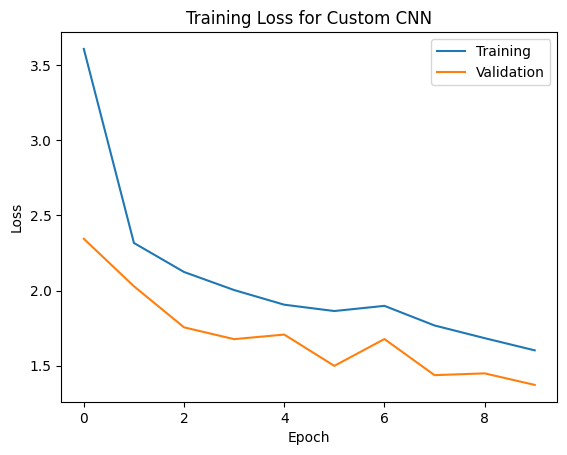

In [44]:
# Plot the loss curve
plt.plot(train_losses, label="Training")
plt.plot(valid_losses, label="Validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss for Custom CNN")
plt.show()

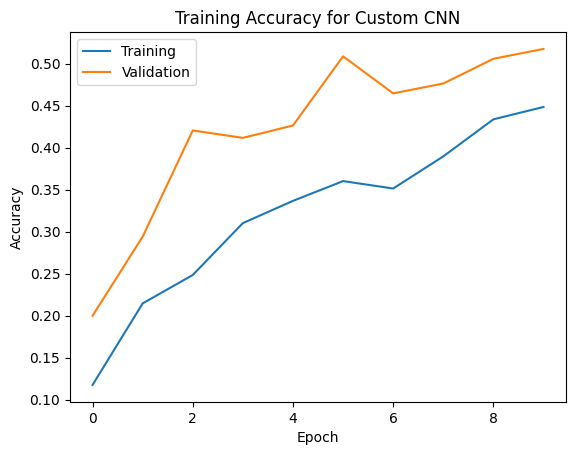

In [45]:
# Plot the accuracy curve
plt.plot(train_accs, label="Training")
plt.plot(valid_accs, label="Validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy for Custom CNN")
plt.show()